In [1]:
import csv
import dataset_loader
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import similarity
import sklearn.svm as svm
import sklearn.model_selection as model_selection
import tqdm
from typing import List, Tuple

In [2]:
DATASET_ROOT="../../sabana/dataset/asap-dataset"
# DATASET_ROOT="../../sabana/dataset/newbie-dataset"

In [3]:
SLICE_DURATION = 5 # sec
EXPANSION_RATE = 1.5
FRAME_PER_SECOND = 20 # Hz
NUM_SAMPLES = 100
QUEUE_SIZE = 8
SETTLING_FRAME = 8
COMPENSATION_FRAME = 0
USE_SUBSEQUENCE_DTW = True
USE_DECAY_FOR_HISTOGRAM = True

SAVE_ROOT = pathlib.Path("./save")

if not SAVE_ROOT.exists():
    SAVE_ROOT.mkdir(exist_ok=True, parents=True)


In [4]:
dataset = dataset_loader.spawn(dataset_root=DATASET_ROOT, 
                               slice_duration=SLICE_DURATION,
                               expansion_rate=EXPANSION_RATE,
                               frame_per_second=FRAME_PER_SECOND,
                               shuffle=True)

# pos/neg-similarities: [histogram_distance, timewarping_distance, length_ratio]
pos_similarities: List[Tuple[float, float, float]] = []
neg_similarities: List[Tuple[float, float, float]] = []

prev_perfs: List[np.ndarray] = [None] * QUEUE_SIZE

with open(SAVE_ROOT / "pos.csv", "w", encoding="utf-8") as f1, \
     open(SAVE_ROOT / "neg.csv", "w", encoding="utf-8") as f2:
    pos_csvfile = csv.writer(f1, delimiter=",", quotechar="|")
    pos_csvfile.writerow(["Histogram distance", "Timewarping distance", "Length ratio"])

    neg_csvfile = csv.writer(f2, delimiter=",", quotechar="|")
    neg_csvfile.writerow(["Histogram distance", "Timewarping distance", "Length ratio"])

    try:
        for idx in tqdm.trange(NUM_SAMPLES, desc="Measuring similarities..."):
            score, perf, _ = next(dataset)
            score_len = score.shape[-1]
            perf_len = perf.shape[-1]
            pos_histogram_distance, pos_timewarping_distance, _ = similarity.measure(score, perf,
                                                                                    settling_frame=SETTLING_FRAME,
                                                                                    compensation_frame=COMPENSATION_FRAME,
                                                                                    use_subsequence_dtw=USE_SUBSEQUENCE_DTW,
                                                                                    use_decay_for_histogram=USE_DECAY_FOR_HISTOGRAM)
            pos_length_ratio = perf_len / (score_len + 1e-7)
            pos_csvfile.writerow([pos_histogram_distance, pos_timewarping_distance, pos_length_ratio])
            pos_similarities.append((pos_histogram_distance, pos_timewarping_distance, pos_length_ratio))
            
            if isinstance(prev_perfs[0], np.ndarray):
                prev_perf = prev_perfs[0]
                prev_perf_len = prev_perf.shape[-1]
                neg_histogram_distance, neg_timewarping_distance, _ = similarity.measure(score, prev_perf,
                                                                                        settling_frame=SETTLING_FRAME,
                                                                                        compensation_frame=COMPENSATION_FRAME,
                                                                                        use_subsequence_dtw=USE_SUBSEQUENCE_DTW,
                                                                                        use_decay_for_histogram=USE_DECAY_FOR_HISTOGRAM)
                neg_length_ratio = prev_perf_len / (score_len + 1e-7)
                neg_csvfile.writerow([neg_histogram_distance, neg_timewarping_distance, neg_length_ratio])
                neg_similarities.append((neg_histogram_distance, neg_timewarping_distance, neg_length_ratio))

            prev_perfs.pop(0)
            prev_perfs.append(perf)
    except StopIteration:
        print("Loading dataset is finished at iteration {idx}.")

Measuring similarities...: 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


In [5]:
pos_similarities = np.array(pos_similarities)
neg_similarities = np.array(neg_similarities)
print(pos_similarities.shape)
print(neg_similarities.shape)

(100, 3)
(92, 3)


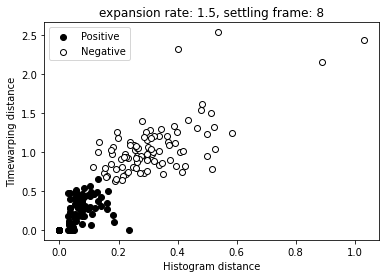

<Figure size 432x288 with 0 Axes>

In [6]:
fig = plt.figure("scatter_2d")
ax = fig.gca()
ax.set_title(f"expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME}")
ax.set_xlabel("Histogram distance")
ax.set_ylabel("Timewarping distance")
ax.scatter(pos_similarities[:, 0], pos_similarities[:, 1], c="k", label="Positive")
ax.scatter(neg_similarities[:, 0], neg_similarities[:, 1], c="w", edgecolors="k", label="Negative")
plt.legend()
plt.show()
plt.clf()

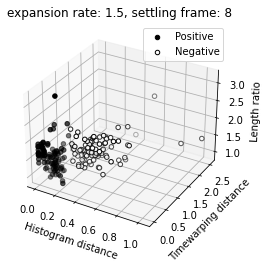

<Figure size 432x288 with 0 Axes>

In [7]:
fig = plt.figure("scatter_3d")
ax = fig.gca(projection="3d")
ax.set_title(f"expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME}")
ax.set_xlabel("Histogram distance")
ax.set_ylabel("Timewarping distance")
ax.set_zlabel("Length ratio")
ax.scatter(pos_similarities[:,0], pos_similarities[:,1], pos_similarities[:,2], c="k", label="Positive")
ax.scatter(neg_similarities[:,0], neg_similarities[:,1], neg_similarities[:,2], c="w", edgecolors="k", label="Negative")
plt.legend()
plt.show()
plt.clf()

In [8]:
x_total = np.concatenate([pos_similarities, neg_similarities])
y_total = np.array([+1 for _ in range(len(pos_similarities))] + [-1 for _ in range(len(neg_similarities))])
print(x_total.shape)
print(y_total.shape)

(192, 3)
(192,)


In [9]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_total, y_total, test_size=0.2, stratify=y_total, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(153, 3)
(153,)
(39, 3)
(39,)


In [10]:
svm_linear_2d = svm.SVC(kernel="linear")
svm_linear_2d.fit(x_train[:, 0:2], y_train)
print("SVM(linear) Accuracy:", svm_linear_2d.score(x_test[:, 0:2], y_test))

SVM(linear) Accuracy: 1.0


In [11]:
svm_linear_3d = svm.SVC(kernel="linear")
svm_linear_3d.fit(x_train, y_train)
print("SVM(linear) Accuracy:", svm_linear_3d.score(x_test, y_test))

SVM(linear) Accuracy: 1.0


In [12]:
svm_poly3 = svm.SVC(kernel="poly", degree=3)
svm_poly3.fit(x_train, y_train)
print("SVM(poly_3) Accuracy:", svm_poly3.score(x_test, y_test))

SVM(poly_3) Accuracy: 0.9743589743589743


In [13]:
svm_poly5 = svm.SVC(kernel="poly", degree=5)
svm_poly5.fit(x_train, y_train)
print("SVM(poly_5) Accuracy:", svm_poly5.score(x_test, y_test))

SVM(poly_5) Accuracy: 0.9743589743589743


In [14]:
svm_poly7 = svm.SVC(kernel="poly", degree=7)
svm_poly7.fit(x_train, y_train)
print("SVM(poly_7) Accuracy:", svm_poly7.score(x_test, y_test))

SVM(poly_7) Accuracy: 0.9743589743589743


In [15]:
svm_rbf = svm.SVC(kernel="rbf")
svm_rbf.fit(x_train, y_train)
print("SVM(rbf) Accuracy:", svm_rbf.score(x_test, y_test))

SVM(rbf) Accuracy: 1.0
